# Concept Annotation Inspection

This notebook compares the concept annotations that users marked as broken/incorrect with concept annotations that are missing from updated Pubtator files (ie- were dropped by Pubtator).  This book focuses only on concept annotations WITH an associated identifier, since there are issues mapping concepts without identifiers in the Mark2Cure database.

## Import modules and data

In [1]:
import pandas
import numpy
import random
import matplotlib
from matplotlib import pyplot as mplot
import m2c_rel_basic
import relationship_dictionaries
from pandas import read_csv
from nltk.metrics.scores import precision
from nltk.metrics.scores import recall
from nltk.metrics.scores import f_measure

Import the relationship annotations data for only completed concept pairs. This data should have already been filtered to remove annotations from test accounts

In [3]:
savepath = 'data/'
exppath = 'exports/'
all_completed_anns = read_csv(savepath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)

Import the pubtator concept annotations from the database export

In [4]:
conceptsource = '2017.11.22 RE pubmed concept export.txt'
pubsource = '2017.11.22 pubtator export_parsed_pubtator_anns_from_db_all_anns.txt'
all_concept_imported = read_csv(savepath+conceptsource, delimiter='\t', header=0)

Import the updated pubtator files stored in the database and save the annotations

In [5]:
pubtator_key = m2c_rel_basic.get_pub_anns(savepath+pubsource)
print(pubtator_key.head(n=3))

Importing your data...
       pmid     identifier        id_type  \
0  19067230  no identifier  no identifier   
1  19067230        D018981           MESH   
2  19067230        D006527           MESH   

                                   text     type length offset  
0                 hypertransaminasaemia  Disease     21     19  
1  congenital disorder of glycosylation  Disease     36     51  
2                        Wilson disease  Disease     14    321  


In [6]:
rel_hash_dict,redundant_response_dict,abbreviated_rels_dict,abbreviated_rels_dict_4_hash,concept_broken_dict,concept_not_broken_dict = relationship_dictionaries.load_RE_dictionaries()

## Compare original Pubtator Annotations with annotations from updated pubtator files

As an active project, the NER algorithms used in Pubtator are steadily improving even as the annotations are used in different projects like Mark2Cure.  Hence, annotations pulled at one timepoint may be inferior to annotations pulled at a later date. To inspect the potential contributions of citizen scientists to an actively improving project like pubtator, we inspect the annotations that are thrown out by the users with respect to the annotations that are thrown out by pubtator later on.

#### Standardize format of stored pubtator annotations (that were shown to users) and pubtator annotations (from updated pubtator files) for ease of comparison.

In [7]:
##filter pubtator table for pmids currently in the database export of imported annotations
rel_pmid_list = all_concept_imported['pmid'].unique().tolist()
tmp_pub_key = pubtator_key[['pmid','text','identifier','type','offset','length']].copy()
tmp_pub_key['pmid'] = tmp_pub_key['pmid'].astype(int)
corresponding_pubs = tmp_pub_key.loc[tmp_pub_key['pmid'].isin(rel_pmid_list)].copy()

##format data from the database export and those pulled from updated pubtator files to be the same
corresponding_pubs['type'] = corresponding_pubs['type'].astype(str).str[0].str.lower()
all_concept_imported.rename(columns={'stype':'type', 'concept_id':'identifier'},inplace=True)
all_concept_imported['identifier'].replace({'None':'no identifier'}, inplace=True)

## Remove species annotations since they should not be in the concept db
no_species = corresponding_pubs[corresponding_pubs['type']!='s']

## Save these results for downstream concept distance analysis
no_species.to_csv(savepath+'concept_anns_from_updated_pub_files.txt',sep='\t',header=True)
all_concept_imported.to_csv(savepath+'concepts_anns_from_db.txt',sep='\t',header=True)

#### Separate out pubtator annotations that lack identifiers from both sources. These will be treated differently.

In [8]:
## Remove annotations without identifiers
no_nones = no_species.loc[no_species['identifier']!='no identifier']
no_nones_concepts = all_concept_imported.loc[all_concept_imported['identifier']!='no identifier']

## Remove duplicates from multiple mentions from each annotation source
no_dups = no_nones.groupby(['pmid','identifier','type']).size().reset_index(name='no_of_mentions_pub')
no_dups['in_pubtator']='yes'

no_dups_concepts = no_nones_concepts.groupby(['pmid','identifier','type']).size().reset_index(name='no_of_mentions_db')
no_dups_concepts['in_db']='yes'

## Outer Merge the formatted tables to identify annotations that did not change, were added, or dropped
concept_annotations = no_dups_concepts.merge(no_dups, on=(['pmid','identifier','type']), how='outer').fillna('no')
concept_annotations['pmid']=concept_annotations['pmid'].astype(int)

unchanged_anns = concept_annotations.loc[(concept_annotations['in_db']=='yes') & 
                                        (concept_annotations['in_pubtator']=='yes')]
dropped_anns = concept_annotations.loc[(concept_annotations['in_db']=='yes') & 
                                        (concept_annotations['in_pubtator']=='no')]
added_anns = concept_annotations.loc[(concept_annotations['in_db']=='no') & 
                                        (concept_annotations['in_pubtator']=='yes')]  

print('Annotations that were unchanged after pubtator update: ',len(unchanged_anns),' dropped: ',len(dropped_anns),' added: ',len(added_anns))

Annotations that were unchanged after pubtator update:  7403  dropped:  2551  added:  3668


In [9]:
print(dropped_anns.head(n=2))

     pmid identifier type no_of_mentions_db in_db no_of_mentions_pub  \
0  501285    C039522    c                 1   yes                 no   
2  501285    D003920    d                 3   yes                 no   

  in_pubtator  
0          no  
2          no  


In [19]:
## Merge back the dropped annotations to get the text that corresponds to the identifier
dropped_anns_with_text = dropped_anns.merge(all_concept_imported, on=(['pmid','identifier','type']), how='left')
print(len(dropped_anns))
print(len(dropped_anns_with_text))
print(dropped_anns_with_text.head(n=2))
##Store annotations dropped by pubtator for further downstream processing
dropped_anns_with_text.to_csv(savepath+'dropped_by_pubtator.txt',sep='\t',header=True)

2551
2737
     pmid identifier type no_of_mentions_db in_db no_of_mentions_pub  \
0  501285    C039522    c                 1   yes                 no   
1  501285    D003920    d                 3   yes                 no   

  in_pubtator                                             text  
0          no                              glycosylated lysine  
1          no  Cataractous lenses of diabetic and galactosemic  


#### Pull the annotations that users marked as broken and see if they are ones that were thrown out by pubtator

In [11]:
#### Use dictionary to flatten user responses to broken vs not broken
#### Do precision, recall, f, setting reference 'broken ann' set as missing vs not missing in pubtator
#### Do precision, recall, f, setting reference 'broken ann' set as annotations where at least 6 users agree.
#### Chart the two out and compare.

#### Alternative subset annotations by whether or not they are missing from pubtator
#### Then check precision, recall, f, when reference is at least 6 users. Plot on same graph.


In [12]:
#### Remove user annotations for concepts without identifiers
nonones_annresults = all_completed_anns.loc[(all_completed_anns['refid1']!='None')&(all_completed_anns['refid2']!='None')].copy()

#### Save these annotations for downstream analysis on concept distance
nonones_annresults.to_csv(savepath+'REanns_on_concepts_with_identifiers_only.txt',sep='\t',header=True)

In [13]:
nonones_annresults['ann_status'] = 'TBD'
nonones_annresults['ann_status'].loc[nonones_annresults['evtype']=='c_1_broken'] = 'c1_broken'
nonones_annresults['ann_status'].loc[nonones_annresults['evtype']=='c_2_broken'] = 'c2_broken'
nonones_annresults['ann_status'].loc[(nonones_annresults['evtype']!='c_1_broken')&(nonones_annresults['evtype']!='c_2_broken')]= 'not_broken'
nonones_annresults['cp1_hash'] = nonones_annresults['pmid'].astype(str).str.cat(nonones_annresults['refid1'].astype(str),sep='_')
nonones_annresults['cp2_hash'] = nonones_annresults['pmid'].astype(str).str.cat(nonones_annresults['refid2'].astype(str),sep='_')

df_to_analyze = nonones_annresults[['user_id','evtype','cp1_hash','cp2_hash','cpmid','ann_status','pmid']].copy()
print(df_to_analyze.head(n=2))


   user_id                           evtype       cp1_hash         cp2_hash  \
0      364  gene has no relation to disease  9621534_59330  9621534_D001750   
1      364                       c_1_broken  9621534_59330  9621534_D005764   

                     cpmid  ann_status     pmid  
0  9621534_59330_x_D001750  not_broken  9621534  
1  9621534_59330_x_D005764   c1_broken  9621534  


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
#### For each cpmid that was completed by at least 15 users
#### Pull the pmids from this set, and use it to limit the reference set.
completed_pmids = set(df_to_analyze['pmid'].astype(int).tolist())

## Set the dropped annotations as the reference set of broken annotations
dropped_anns_id = dropped_anns.loc[dropped_anns['pmid'].isin(completed_pmids)].copy()
dropped_anns_id['cphash'] = dropped_anns['pmid'].astype(str).str.cat(dropped_anns['identifier'].astype(str),sep='_')

dropped_id_ref_set = set(dropped_anns_id['cphash'].tolist())

## Set the kept annotations as the reference set of unbroken annotations
kept_anns = unchanged_anns.loc[unchanged_anns['pmid'].isin(completed_pmids)].copy()
kept_anns['cphash'] = kept_anns['pmid'].astype(str).str.cat(kept_anns['identifier'].astype(str),sep='_')
ref_set = set(kept_anns['cphash'].tolist())


In [ ]:
#### Note, there are over 1000 cpmids to be analyzed, so this part may take awhile
## Each of the 1000 cpmids will be sampled for k users 10 times and analyzed for p,r,f
k=1
cpmidlist = set(df_to_analyze['cpmid'].tolist())
#cpmidlist = ('10068747_5443_x_C536008','10068747_5443_x_C536009','9621534_59330_x_D005764')
cpmid_result = []
iterations = 10
cpmid_sample_larger_than_population =[]
while k <= 15:
    i=0
    print('now working on k =',k)
    while i< iterations:
        trial_check = {'k':k,'iteration':i}
        trial_df = pandas.DataFrame(columns=['user_id','evtype','cp1_hash','cp2_hash','cpmid','ann_status','pmid'])
        ## randomly sample users from the set of users that did that particular cpmid to generate a data frame of k responses per cpmid
        for eachcpmid in cpmidlist: 
            tmpdf = df_to_analyze.loc[df_to_analyze['cpmid']==eachcpmid].copy()
            user_set = set(tmpdf['user_id'].tolist())
            try:
                user_sample = random.sample(user_set, k)
                tmp_sample = tmpdf.loc[tmpdf['user_id'].isin(user_sample)].copy()
                trial_df = pandas.concat((trial_df,tmp_sample)).reset_index(drop=True)
            except:
                cpmid_sample_larger_than_population.append(eachcpmid)
        ## Get a count of the responses
        response_count = trial_df.groupby(['cp1_hash','cp2_hash','cpmid','ann_status']).size().reset_index(name='res_count')
        ## Deal with unanimous responses
        unanimous_subset = response_count.loc[response_count['res_count']==k].copy()
        ## Toss unanimous broken responses to broken set, unanimous not broken responses to reference set
        u_cp1_broken = set(unanimous_subset['cp1_hash'].loc[unanimous_subset['ann_status']=='c1_broken'].tolist())
        u_cp2_broken = set(unanimous_subset['cp2_hash'].loc[unanimous_subset['ann_status']=='c2_broken'].tolist())
        u_cp1_fine = set(unanimous_subset['cp1_hash'].loc[unanimous_subset['ann_status']=='not_broken'].tolist())
        u_cp2_fine = set(unanimous_subset['cp2_hash'].loc[unanimous_subset['ann_status']=='not_broken'].tolist())
        ## Deal with the non-unanimous responses
        not_unanimous = response_count.loc[response_count['res_count']<k].copy() #response count should never be more than k
        not_unanimous.sort_values(['cpmid','res_count'],ascending=[False,False],inplace=True)
        ## Deal with the tied-responses
        not_unanimous['tied'] = not_unanimous.duplicated(subset=['cpmid','res_count'],keep=False)
        ## Keep the top result if it is NOT a tied result
        top_results = not_unanimous.drop_duplicates(subset='cpmid', keep='first',inplace=False)
        majority_rules = top_results.loc[top_results['tied']==False].copy()
        mj_cp1_broken = set(majority_rules['cp1_hash'].loc[majority_rules['ann_status']=='c1_broken'].tolist())
        mj_cp2_broken = set(majority_rules['cp2_hash'].loc[majority_rules['ann_status']=='c2_broken'].tolist())
        mj_cp1_fine = set(majority_rules['cp1_hash'].loc[majority_rules['ann_status']=='not_broken'].tolist())
        mj_cp2_fine = set(majority_rules['cp2_hash'].loc[majority_rules['ann_status']=='not_broken'].tolist())
        ## Generate dataframe of annotations in which the top result was tied
        tied_top_cpmids = top_results['cpmid'].loc[top_results['tied']==True].tolist()
        tied_results = not_unanimous.loc[not_unanimous['cpmid'].isin(tied_top_cpmids)].copy()
        ## randomly select one of the tied results to be the correct response
        tied_results['rand_value'] = numpy.random.randint(1, 6, tied_results.shape[0])
        tied_results.sort_values(['cpmid','rand_value'],ascending=['False','False'], inplace=True)
        tied_untied = tied_results.drop_duplicates(subset='cpmid', keep='first',inplace=False)
        tut_cp1_broken = set(tied_untied['cp1_hash'].loc[tied_untied['ann_status']=='c1_broken'].tolist())
        tut_cp2_broken = set(tied_untied['cp2_hash'].loc[tied_untied['ann_status']=='c2_broken'].tolist())
        tut_cp1_fine = set(tied_untied['cp1_hash'].loc[tied_untied['ann_status']=='not_broken'].tolist())
        tut_cp2_fine = set(tied_untied['cp2_hash'].loc[tied_untied['ann_status']=='not_broken'].tolist())
        ## Create the sets of cphashes to be checked
        broken_set = u_cp1_broken.union(u_cp2_broken.union(mj_cp1_broken.union(mj_cp2_broken.union(tut_cp1_broken.union(tut_cp2_broken)))))
        test_set = u_cp1_fine.union(u_cp2_fine.union(mj_cp1_fine.union(mj_cp2_fine.union(tut_cp1_fine.union(tut_cp2_fine)))))
        ## Format and store the results
        broke_p = precision(dropped_id_ref_set,broken_set)
        broke_r= recall(dropped_id_ref_set,broken_set)
        broke_f= f_measure(dropped_id_ref_set,broken_set)
        prcsn = precision(ref_set,test_set)
        rcl = recall(ref_set,test_set)
        fmeas = f_measure(ref_set,test_set)
        trial_check['total_cpmids'] = len(cpmidlist)
        trial_check['unanimous'] = len(unanimous_subset)
        trial_check['majority_ruled'] = len(majority_rules)
        trial_check['tied_top'] = len(tied_untied)
        trial_check['broken_user_anns'] = len(broken_set)
        trial_check['not_broken_user_anns'] = len(test_set)
        trial_check['broken_prcsn'] = broke_p
        trial_check['broken_rcl'] = broke_r
        trial_check['broken_fmeas'] = broke_f
        trial_check['precision'] = prcsn
        trial_check['recall'] = rcl
        trial_check['fmeas'] = fmeas
        cpmid_result.append(trial_check)
        i=i+1
    k=k+1

prclf = pandas.DataFrame(cpmid_result)

now working on k = 1
now working on k = 2
now working on k = 3
now working on k = 4
now working on k = 5
now working on k = 6
now working on k = 7
now working on k = 8
now working on k = 9


In [60]:
## Export the result to save time on having to run it again
#prclf.to_csv(exppath+'identified_broken_anns_vs_dropped_pubtators.txt',sep='\t',header=True)
#print(len(set(cpmid_sample_larger_than_population)))

In [15]:
#Import precision, mean, f-score df if needed. 
prclf = read_csv(exppath+'identified_broken_anns_vs_dropped_pubtators.txt', delimiter='\t', header=0)
prclf.drop("Unnamed: 0",axis=1,inplace=True)

In [16]:
#Calculate mean precision, recall, and f-scores
print(prclf.head(n=2))
mean_fmeas = prclf.groupby('k').fmeas.mean().reset_index(name='mean_f')
mean_prcsn = prclf.groupby('k').precision.mean().reset_index(name='mean_p')
mean_recall = prclf.groupby('k').recall.mean().reset_index(name='mean_r')
sem_fmeas = prclf.groupby('k').fmeas.sem().reset_index(name='sem_f')
sem_prcsn = prclf.groupby('k').precision.sem().reset_index(name='sem_p')
sem_recall = prclf.groupby('k').recall.sem().reset_index(name='sem_r')
stats_result = mean_prcsn.merge(mean_recall.merge(mean_fmeas.merge(sem_fmeas.merge(sem_prcsn.merge(sem_recall, on='k', how='left'), on='k', how='left'), on='k', how='left'), on='k', how='left'), on='k', how='left')
print(stats_result)

   broken_fmeas  broken_prcsn  broken_rcl  broken_user_anns     fmeas  \
0      0.276256      0.320106    0.242972               378  0.490855   
1      0.294785      0.338542    0.261044               384  0.505325   

   iteration  k  majority_ruled  not_broken_user_anns  precision    recall  \
0          0  1               0                   659   0.631259  0.401544   
1          1  1               0                   654   0.652905  0.412162   

   tied_top  total_cpmids  unanimous  
0         0           975        968  
1         0           975        965  
     k    mean_p    mean_r    mean_f     sem_f     sem_p     sem_r
0    1  0.646167  0.416506  0.506489  0.002469  0.002619  0.002623
1    2  0.642555  0.400483  0.493396  0.002078  0.001482  0.002461
2    3  0.628327  0.385907  0.478105  0.003464  0.002582  0.003662
3    4  0.630229  0.380695  0.474654  0.001924  0.002102  0.001861
4    5  0.620229  0.365444  0.459875  0.002693  0.002550  0.002750
5    6  0.620617  0.366120

Based on these results, the annotations that are getting rejected by users are not necessarily the same annotations getting thrown out by pubtator, suggesting that there are still interesting differences between what pubtator is tossing out vs what the users are throwing out.

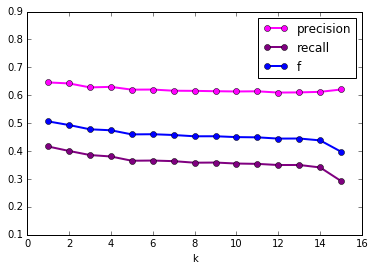

In [32]:
#### Visualize the results
mplot.plot(stats_result['k'],stats_result['mean_p'], linewidth=2.0, color='magenta',marker='o',label="precision")
mplot.plot(stats_result['k'],stats_result['mean_r'], linewidth=2.0, color='purple',marker='o',label="recall")
mplot.plot(stats_result['k'],stats_result['mean_f'], linewidth=2.0, color='blue',marker='o',label="f")
mplot.ylim(0.1,0.9)
mplot.xlabel('k')
mplot.legend()
mplot.show()